# Aggregate Multiple Result Files

In [3]:
import os
import time
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json
import math
from tabulate import tabulate
from scipy.stats import norm, ttest_ind, f_oneway, t, shapiro, levene, mannwhitneyu, wilcoxon, kruskal
import itertools
from matplotlib.ticker import MaxNLocator
from collections import defaultdict

In [4]:
files = [
    os.path.join("results","all_trials_verbal_deepseek.json") ,
    os.path.join( "results","all_trials_verbal_deepseek_2.json"),
        os.path.join( "results","all_trials_verbal_deepseek_3.json") 

]

new_file = os.path.join( "results","all_trials_verbal_deepseek_aggregate[1-3].json")
print(f"Aggregating files:")
for f in files:
    print(f" - {f}")
print(f"Saving aggregated results to: {new_file}")

if os.path.exists(new_file):
    ans = input(f"File {new_file} already exists. Do you want to overwrite it? (y/n): ")
    if ans.lower() != 'y':
        raise FileExistsError(f"File {new_file} already exists. Aborting to prevent overwrite.")

Aggregating files:
 - results/all_trials_verbal_deepseek.json
 - results/all_trials_verbal_deepseek_2.json
 - results/all_trials_verbal_deepseek_3.json
Saving aggregated results to: results/all_trials_verbal_deepseek_aggregate[1-3].json


In [5]:
trials = []
for f in files:
    with open(f, "r",) as fp:
        trials.append(json.load(fp))

In [6]:
all_trials = {}
next_block_num = defaultdict(int)  # Keeps track of the next block number for each n-back condition
for trial_set in trials:
    for key in trial_set:
        test,_ = key.split('_')  # e.g., '1back', '2back'
        block_num = next_block_num[test]
        new_key = f"{test}_{block_num}"
        all_trials[new_key] = trial_set[key]
        next_block_num[test] += 1
# n_list = int[], e.g., [1, 2, 3]
n_list = [int(key.replace('back', '')) for key in next_block_num.keys()]
bn = set()
for key in next_block_num:
    bn.add(next_block_num[key])
if len(bn) > 1:
    raise ValueError(f"Block numbers are not consistent across conditions: {dict(next_block_num)}")
blocks = bn.pop()  # Get the single block number
print(f"Total blocks: {sum(next_block_num.values())}")
print(f"Total trials: {sum(len(all_trials[key]) for key in all_trials)}")
print(f"{n_list=}")
print(f"{blocks=}")

Total blocks: 450
Total trials: 10800
n_list=[1, 2, 3]
blocks=150


In [7]:
with open(new_file, "w") as fp:
    json.dump(all_trials, fp)

In [8]:
def compute_summary_stats(all_trials, n_list, blocks):
    summary_stats = {}
    raw_data = {}
    for n in n_list:
        hit_rate, false_alarm_rate, accuracy, response_time, d_prime = [], [], [], [], []
        for b in range(blocks):
            trials = all_trials[f"{n}back_{b}"]

            # Compute the hit rate, false alarm rate, and response time
            hits, false_alarms, total_targets, total_lures, total_rt = 0, 0, 0, 0, 0
            for trial in trials:
                if trial['target'] == 'm':
                    total_targets += 1
                    if trial['correct']:
                        hits += 1
                        total_rt += trial['rt']
                else:
                    total_lures += 1
                    if not trial['correct']:
                        false_alarms += 1

            hit_rate.append((hits / total_targets) * 100)
            false_alarm_rate.append((false_alarms / total_lures) * 100)
            accuracy.append(((hits + (total_lures - false_alarms)) / (total_targets + total_lures)) * 100)
            response_time.append(total_rt / hits if hits > 0 else np.nan)

            # Compute d prime
            hit_rate_adjusted = np.clip(hits / total_targets, 0.01, 0.99)
            false_alarm_rate_adjusted = np.clip(false_alarms / total_lures, 0.01, 0.99)
            d_prime.append(np.abs(norm.ppf(hit_rate_adjusted) - norm.ppf(false_alarm_rate_adjusted)))

        raw_data[n] = {
            "hit_rate": hit_rate,
            "false_alarm_rate": false_alarm_rate,
            "accuracy": accuracy,
            "d_prime": d_prime
        }
            
        summary_stats[n] = {
            "hit_rate": {"mean": np.mean(hit_rate),  "stderr": np.std(hit_rate) / math.sqrt(blocks)},
            "false_alarm_rate": {"mean": np.mean(false_alarm_rate), "stderr": np.std(false_alarm_rate) / math.sqrt(blocks)},
            "accuracy": {"mean": np.mean(accuracy), "stderr": np.std(accuracy) / math.sqrt(blocks)},
            "d_prime": {"mean": np.mean(d_prime), "stderr": np.std(d_prime) / math.sqrt(blocks)}
        }
    return summary_stats, raw_data

def create_table(summary_stats, n_list):
    headers = ["N-back", "Hit Rate (%)", "False Alarm Rate (%)",
               "Accuracy (%)", "D Prime"]

    table_data = []
    for n in n_list:
        row = [f"{n}-back",
               f"{summary_stats[n]['hit_rate']['mean']:.2f} ± {summary_stats[n]['hit_rate']['stderr']:.2f}",
               f"{summary_stats[n]['false_alarm_rate']['mean']:.2f} ± {summary_stats[n]['false_alarm_rate']['stderr']:.2f}",
               f"{summary_stats[n]['accuracy']['mean']:.2f} ± {summary_stats[n]['accuracy']['stderr']:.2f}",
               f"{summary_stats[n]['d_prime']['mean']:.2f} ± {summary_stats[n]['d_prime']['stderr']:.2f}"]
        table_data.append(row)

    table_str = tabulate(table_data, headers=headers, tablefmt="latex_booktabs")
    return table_str

# Compute summary statistics
summary_stats, raw_data = compute_summary_stats(all_trials, n_list, blocks)

# Create and print the table in LaTeX format
latex_table = create_table(summary_stats, n_list)
print(latex_table)


\begin{tabular}{lllll}
\toprule
 N-back   & Hit Rate (\%)   & False Alarm Rate (\%)   & Accuracy (\%)   & D Prime     \\
\midrule
 1-back   & 100.00 ± 0.00  & 0.54 ± 0.17            & 99.64 ± 0.11   & 4.59 ± 0.02 \\
 2-back   & 53.67 ± 1.92   & 4.08 ± 0.40            & 81.83 ± 0.70   & 2.01 ± 0.08 \\
 3-back   & 22.42 ± 1.54   & 2.46 ± 0.33            & 72.50 ± 0.52   & 1.10 ± 0.07 \\
\bottomrule
\end{tabular}


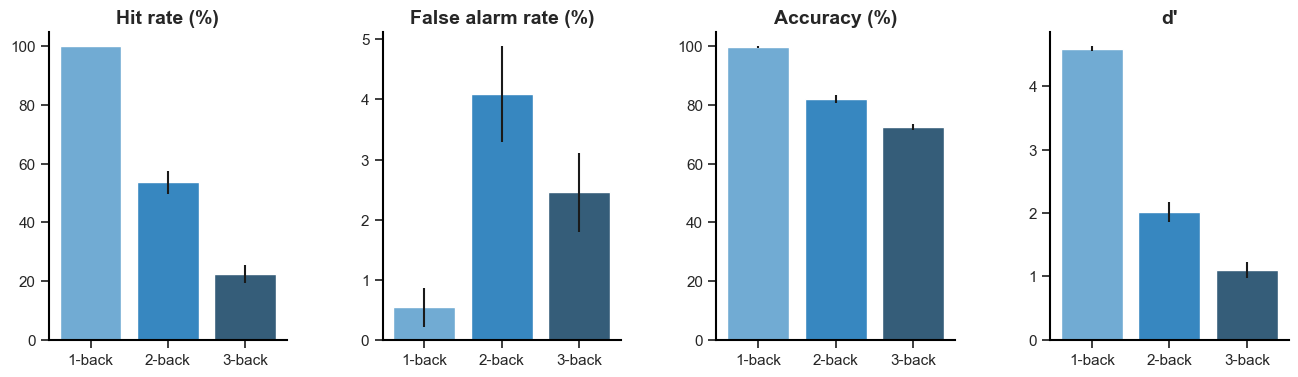

In [15]:
def plot_metrics(summary_stats, n_list, ci_level=0.95, save_path=None):
    sns.set(style="whitegrid")
    plt.rcParams.update({'font.size': 12})

    # 1x4 layout
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    metrics = ["hit_rate", "false_alarm_rate", "accuracy", "d_prime"]
    titles = ["Hit rate (%)", "False alarm rate (%)", "Accuracy (%)", "d'"]

    for i, ax in enumerate(axes):  # axes is 1D now
        metric = metrics[i]
        means = [summary_stats[n][metric]["mean"] for n in n_list]
        stderrs = [summary_stats[n][metric]["stderr"] for n in n_list]

        critical_value = t.ppf((1 + ci_level) / 2, blocks - 1)
        cis = [critical_value * stderr for stderr in stderrs]
        error_bars = cis  # or stderrs

        x_positions = range(len(n_list))
        ax.bar(
            x_positions,
            means,
            yerr=error_bars,
            color=sns.color_palette("Blues_d", len(n_list))
        )

        ax.set_title(titles[i], fontsize=14, fontweight='bold')
        ax.set_xticks(list(x_positions))
        ax.set_xticklabels([f"{n}-back" for n in n_list])
        ax.set_ylim(bottom=0)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(False)

        ax.spines['bottom'].set_linewidth(1.5)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_color('black')
        ax.tick_params(axis='both', which='both', bottom=True, left=True)

    plt.subplots_adjust(wspace=0.4, hspace=0.0)
    plt.show()

    if save_path is not None:
        fig.savefig(save_path, format="svg", bbox_inches="tight")
#save_path=  os.path.join("..","figures", "letter_nback_metrics_deepseek.svg")
plot_metrics(summary_stats, n_list)


In [10]:
def statistical_test(summary_stats, raw_data, n_list, blocks, alpha=0.05):
    metrics = ["hit_rate", "false_alarm_rate", "accuracy", "d_prime"]

    for metric in metrics:
        print(f"ANOVA for {metric}:")

        # Prepare the data for ANOVA
        data = [np.array(raw_data[n][metric]) for n in n_list]

        # Perform ANOVA
        F, p = f_oneway(*data)

        # Calculate degrees of freedom
        df_between = len(n_list) - 1
        df_within = blocks * len(n_list) - len(n_list)

        # Calculate partial eta squared
        ss_total = np.sum([(d - np.mean(data))**2 for d in itertools.chain.from_iterable(data)])
        ss_effect = sum(blocks * (np.mean(data[i]) - np.mean(np.concatenate(data)))**2 for i in range(len(n_list)))
        partial_eta_squared = ss_effect / (ss_effect + ss_total)

        print(f"  F({df_between}, {df_within}) = {F:.4f}, p = {p:.4f}, partial eta squared = {partial_eta_squared:.4f}")

        # Perform post-hoc t-tests
        print("  Post-hoc t-tests:")
        for combo in itertools.combinations(n_list, 2):
            n1, n2 = combo
            data1 = raw_data[n1][metric]
            data2 = raw_data[n2][metric]

            # t-test
            t_stat, p_value = ttest_ind(data1, data2)

            # Calculate degrees of freedom for t-test
            df_t = 2 * blocks - 2

            # Bonferroni correction
            corrected_p = min(p_value * len(list(itertools.combinations(n_list, 2))), 1)

            # Calculate Cohen's d
            pooled_std = np.sqrt((np.std(data1)**2 + np.std(data2)**2) / 2)
            cohen_d = (np.mean(data1) - np.mean(data2)) / pooled_std

            print(f"    {n1}-back vs {n2}-back: t({df_t}) = {t_stat:.4f}, p = {corrected_p:.4f}, Cohen's d = {cohen_d:.4f}")

        print()

statistical_test(summary_stats, raw_data, n_list, blocks)

ANOVA for hit_rate:
  F(2, 447) = 750.1234, p = 0.0000, partial eta squared = 0.4352
  Post-hoc t-tests:
    1-back vs 2-back: t(298) = 24.0457, p = 0.0000, Cohen's d = 2.7859
    1-back vs 3-back: t(298) = 50.2781, p = 0.0000, Cohen's d = 5.8251
    2-back vs 3-back: t(298) = 12.6590, p = 0.0000, Cohen's d = 1.4666

ANOVA for false_alarm_rate:
  F(2, 447) = 31.0688, p = 0.0000, partial eta squared = 0.1088
  Post-hoc t-tests:
    1-back vs 2-back: t(298) = -8.0830, p = 0.0000, Cohen's d = -0.9365
    1-back vs 3-back: t(298) = -5.1365, p = 0.0000, Cohen's d = -0.5951
    2-back vs 3-back: t(298) = 3.0946, p = 0.0065, Cohen's d = 0.3585

ANOVA for accuracy:
  F(2, 447) = 733.9073, p = 0.0000, partial eta squared = 0.4339
  Post-hoc t-tests:
    1-back vs 2-back: t(298) = 24.9731, p = 0.0000, Cohen's d = 2.8933
    1-back vs 3-back: t(298) = 51.1875, p = 0.0000, Cohen's d = 5.9304
    2-back vs 3-back: t(298) = 10.6725, p = 0.0000, Cohen's d = 1.2365

ANOVA for d_prime:
  F(2, 447) = 87

/Users/tommyshum/Documents/GitHub/FTEC5660/individual_project/ChatGPT-WM/.venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:592: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [11]:
# check the normality of the data
def check_normality(raw_data, n_list, blocks):
    metrics = ["hit_rate", "false_alarm_rate", "accuracy", "d_prime"]

    for metric in metrics:
        print(f"Normality test for {metric}:")

        # Prepare the data for normality test
        data = [np.array(raw_data[n][metric]) for n in n_list]

        # Perform normality test
        W, p = shapiro(np.concatenate(data))

        print(f"  W = {W:.4f}, p = {p:.4f}")

        print()

check_normality(raw_data, n_list, blocks)


Normality test for hit_rate:
  W = 0.8593, p = 0.0000

Normality test for false_alarm_rate:
  W = 0.6115, p = 0.0000

Normality test for accuracy:
  W = 0.8674, p = 0.0000

Normality test for d_prime:
  W = 0.8693, p = 0.0000



In [12]:
# check the homogeneity of the variance
def check_homogeneity(raw_data, n_list, blocks):
    metrics = ["hit_rate", "false_alarm_rate", "accuracy", "d_prime"]

    for metric in metrics:
        print(f"Levene's test for {metric}:")

        # Prepare the data for homogeneity test
        data = [np.array(raw_data[n][metric]) for n in n_list]

        # Perform homogeneity test
        W, p = levene(*data)

        print(f"  W = {W:.4f}, p = {p:.4f}")

        print()

check_homogeneity(raw_data, n_list, blocks)


Levene's test for hit_rate:
  W = 115.0732, p = 0.0000

Levene's test for false_alarm_rate:
  W = 31.0688, p = 0.0000

Levene's test for accuracy:
  W = 107.4459, p = 0.0000

Levene's test for d_prime:
  W = 97.9401, p = 0.0000



Distribution plot for hit_rate:


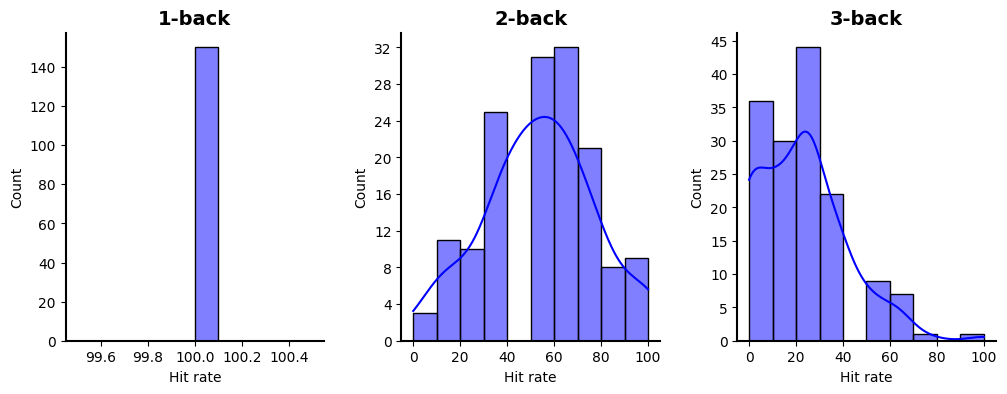

Distribution plot for false_alarm_rate:


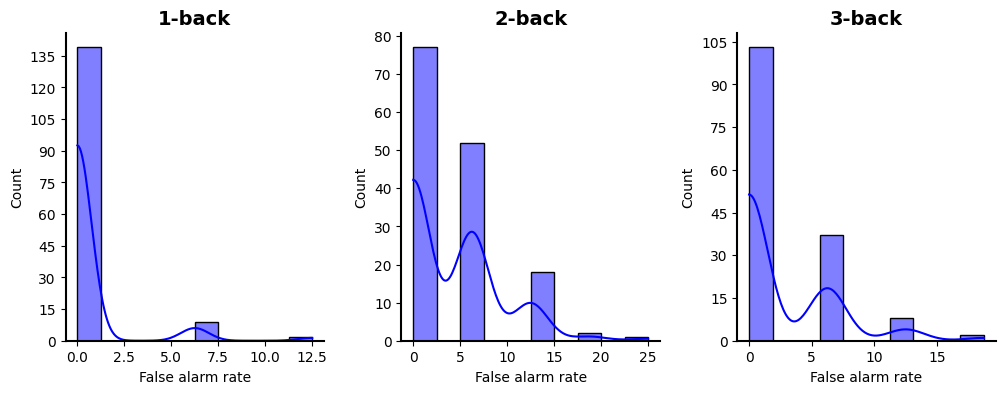

Distribution plot for accuracy:


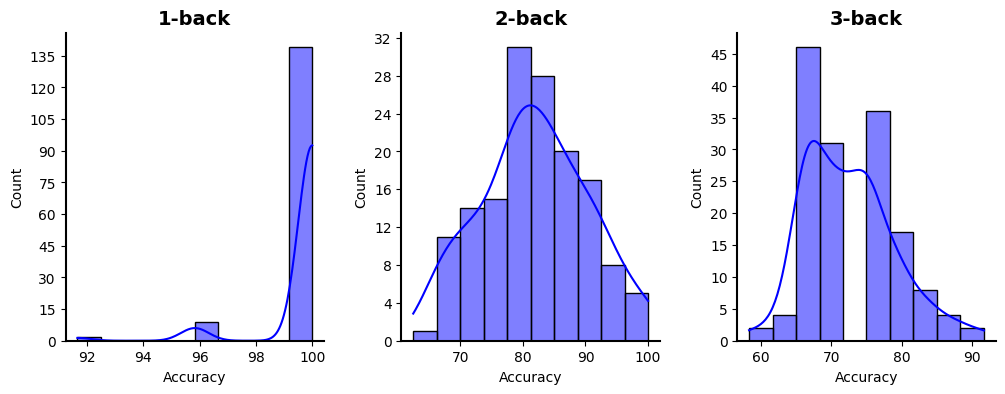

Distribution plot for d_prime:


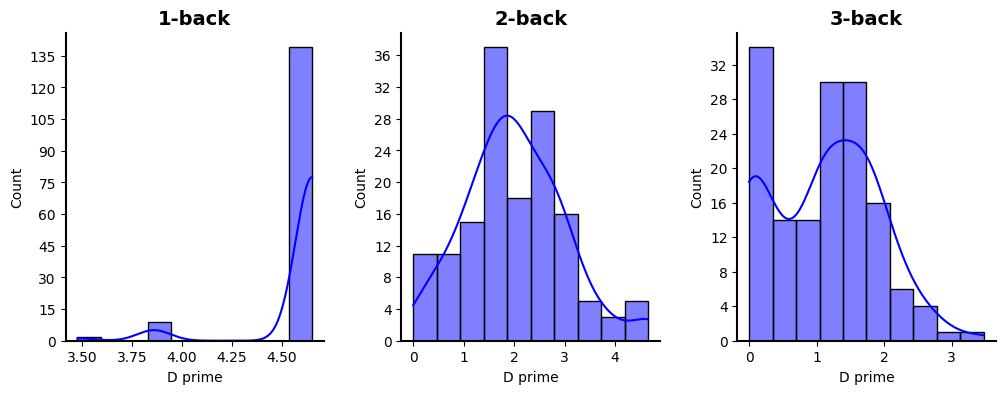

In [13]:
# plot the distribution of the data
def plot_distribution(raw_data, n_list, blocks):
    metrics = ["hit_rate", "false_alarm_rate", "accuracy", "d_prime"]

    for metric in metrics:
        print(f"Distribution plot for {metric}:")

        # Prepare the data for distribution plot
        data = [np.array(raw_data[n][metric]) for n in n_list]

        # Perform distribution plot
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        for i, ax in enumerate(axes.flat):
            sns.histplot(data[i], ax=ax, color="blue", bins=10, kde=True, stat='count')
            # sns.displot(data[i], ax=ax, kde=True, color="black")
            # sns.distplot(data[i], ax=ax, color="blue")
            ax.set_title(f"{n_list[i]}-back", fontsize=14, fontweight='bold')
            ax.set_xlabel(metric.replace("_", " ").capitalize())
            ax.set_ylabel("Count")
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            # remove the grid lines
            ax.grid(False)
            # set the weight  and color of axes lines
            ax.spines['bottom'].set_linewidth(1.5)
            ax.spines['left'].set_linewidth(1.5)
            ax.spines['bottom'].set_color('black')
            ax.spines['left'].set_color('black')
            # show tick lines on the left and bottom axes
            ax.tick_params(axis='both', which='both', bottom=True, left=True)
            # set y ticks to be integers
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))

        # layout setting: adjust the space between subplots
        plt.subplots_adjust(wspace=0.3, hspace=0.3)
        plt.show()

plot_distribution(raw_data, n_list, blocks)

In [14]:
# As normality test and homogeneity test show that the data is not normal and the variance is not homogeneous, we use the non-parametric test
def nonparametric_test(summary_stats, raw_data, n_list, blocks, alpha=0.05):
    metrics = ["hit_rate", "false_alarm_rate", "accuracy", "d_prime"]

    for metric in metrics:
        print(f"Kruskal-Wallis test for {metric}:")

        # Prepare the data for Kruskal-Wallis test
        data = [np.array(raw_data[n][metric]) for n in n_list]

        # Perform Kruskal-Wallis test
        H, p = kruskal(*data)

        # Calculate degrees of freedom
        df = len(n_list) - 1

        # Calculate the total number of observations
        N = len(raw_data[n_list[0]][metric]) * len(n_list)
        
        # Calculate epsilon squared (ε²):ε² = (H - k + 1) / (N - k), where H is the Kruskal-Wallis H statistic, k is the number of groups (in your case, len(n_list)), N is the total number of observations across all groups
        epsilon_squared = (H - len(n_list) + 1) / (N - len(n_list))

        print(f"  H({df}) = {H:.4f}, p = {p:.4f}, epsilon squared = {epsilon_squared:.4f}")

        # Perform post-hoc Mann-Whitney U test
        print("  Post-hoc Mann-Whitney U test:")
        for combo in itertools.combinations(n_list, 2):
            n1, n2 = combo
            data1 = raw_data[n1][metric]
            data2 = raw_data[n2][metric]

            # Mann-Whitney U test
            U, p_value = mannwhitneyu(data1, data2)

            # Bonferroni correction
            corrected_p = min(p_value * len(list(itertools.combinations(n_list, 2))), 1)

            # Calculate the effect size using the rank-biserial correlation (r): r = 1 – (2U)/ (n1 * n2)
            r = 1 - (2 * U) / (len(data1) * len(data2))

            print(f"    {n1}-back vs {n2}-back: U = {U:.4f}, p = {corrected_p:.4f}, rank-biserial correlation(r) = {r:.4f}")

        print()

nonparametric_test(summary_stats, raw_data, n_list, blocks)

Kruskal-Wallis test for hit_rate:
  H(2) = 348.8876, p = 0.0000, epsilon squared = 0.7760
  Post-hoc Mann-Whitney U test:
    1-back vs 2-back: U = 21825.0000, p = 0.0000, rank-biserial correlation(r) = -0.9400
    1-back vs 3-back: U = 22425.0000, p = 0.0000, rank-biserial correlation(r) = -0.9933
    2-back vs 3-back: U = 19031.5000, p = 0.0000, rank-biserial correlation(r) = -0.6917

Kruskal-Wallis test for false_alarm_rate:
  H(2) = 62.9166, p = 0.0000, epsilon squared = 0.1363
  Post-hoc Mann-Whitney U test:
    1-back vs 2-back: U = 6554.5000, p = 0.0000, rank-biserial correlation(r) = 0.4174
    1-back vs 3-back: U = 8540.0000, p = 0.0000, rank-biserial correlation(r) = 0.2409
    2-back vs 3-back: U = 13323.5000, p = 0.0046, rank-biserial correlation(r) = -0.1843

Kruskal-Wallis test for accuracy:
  H(2) = 339.3076, p = 0.0000, epsilon squared = 0.7546
  Post-hoc Mann-Whitney U test:
    1-back vs 2-back: U = 22028.5000, p = 0.0000, rank-biserial correlation(r) = -0.9581
    1-